<center><h2 style='color:red'>HuBMAP | Pytorch | ViT for Segmentation [Train]<hr>By Kassem@elcaiseri</h2></center>

This Code depends on: <br>
- The lossses are from **https://github.com/JunMa11/SegLoss**
- The base codes are from here: **https://www.kaggle.com/vineeth1999/hubmap-pytorch-efficientunet-offline**

**Update:**
- It's the official code. https://github.com/Beckschen/TransUNet


- It's the paper of the TransUnet. https://arxiv.org/pdf/2102.04306v1.pdf (Thanks for @luciusk)


## Introduction <br>
Implementation of **self attention mechanisms** for computer vision in PyTorch with einsum and einops. Focused on **segmentation**  self-attention modules.

### Note: This is a baseline code

**Update**
- This code starts from vision 10
- **V15**: - Use DiceBCELoss - increase ViT blocks - 
- **V16**: - Apply Official code.
          - Add more options for loss function.

## Imports

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from sklearn.model_selection import GroupKFold

import torch
import torchvision
from torch import nn
from torch.optim import Adam
from torchvision import transforms
from torch.nn import functional as F
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau, CosineAnnealingWarmRestarts

import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from scipy.ndimage.interpolation import zoom

!pip install albumentations==0.4.6
import albumentations as A
from albumentations.pytorch import ToTensorV2

import os
import sys
import time
import random
!unzip "/content/drive/MyDrive/DLProjectData/hubmap_train_256.zip" -d "/content"

Streaming output truncated to the last 5000 lines.
  inflating: /content/masks/afa5e8098_0815.png  
  inflating: /content/__MACOSX/masks/._afa5e8098_0815.png  
  inflating: /content/masks/afa5e8098_0801.png  
  inflating: /content/__MACOSX/masks/._afa5e8098_0801.png  
  inflating: /content/masks/b2dc8411c_0193.png  
  inflating: /content/__MACOSX/masks/._b2dc8411c_0193.png  
  inflating: /content/masks/c68fe75ea_0281.png  
  inflating: /content/__MACOSX/masks/._c68fe75ea_0281.png  
  inflating: /content/masks/095bf7a1f_0482.png  
  inflating: /content/__MACOSX/masks/._095bf7a1f_0482.png  
  inflating: /content/masks/cb2d976f4_1151.png  
  inflating: /content/__MACOSX/masks/._cb2d976f4_1151.png  
  inflating: /content/masks/4ef6695ce_1720.png  
  inflating: /content/__MACOSX/masks/._4ef6695ce_1720.png  
  inflating: /content/masks/afa5e8098_0154.png  
  inflating: /content/__MACOSX/masks/._afa5e8098_0154.png  
  inflating: /content/masks/b9a3865fc_0380.png  
  inflating: /content/__MACO

## Hyperparameters

In [ ]:
class CFG:
    data = 256 #512
    debug=False
    apex=False
    print_freq=100
    num_workers=4
    img_size=256 # appropriate input size for encoder 
    scheduler='CosineAnnealingWarmRestarts' # ['ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts']
    epoch=5 # Change epochs
    criterion= 'DiceBCELoss' #'DiceBCELoss' # ['DiceLoss', 'Hausdorff', 'Lovasz']
    base_model='Unet' # ['Unet']
    encoder = 'vit' # ['attention','efficientnet-b5'] or other encoders from smp
    lr=1e-4
    min_lr=1e-6
    batch_size=4
    weight_decay=1e-6
    gradient_accumulation_steps=1
    seed=2021
    n_fold=5
    trn_fold= 0 #[0, 1, 2, 3, 4]
    train=True
    inference=False
    optimizer = 'Adam'
    T_0=10
    # N=5 
    # M=9
    T_max=10
    #factor=0.2
    #patience=4
    #eps=1e-6
    smoothing=1
    in_channels=3
    vit_blocks=12 #[8, 12]
    vit_linear=1024 #1024
    classes=1
    MODEL_NAME = 'R50-ViT-B_16'

"""

main_dir = '/content/drive/My Drive/DLProjectData/hubmap-256x256/'
train_dir = '/content/drive/My Drive/DLProjectData/hubmap-256x256/train'
masks_dir = '/content/drive/My Drive/DLProjectData/hubmap-256x256/masks'
"""
main_dir = '/content/'
train_dir = '/content/train'
masks_dir = '/content/masks'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# from @Iafoss comment
def seed_torch(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    #the following line gives ~10% speedup
    #but may lead to some stochasticity in the results 
    torch.backends.cudnn.benchmark = True # from @Iafoss comment

seed_torch(seed=CFG.seed)

## Dataset

In [ ]:
train_df = pd.read_csv('/content/drive/My Drive/DLProjectData/train.csv')
train_df.head()

,id,encoding
0,2f6ecfcdf,296084587 4 296115835 6 296115859 14 296147109...
1,8242609fa,96909968 56 96941265 60 96972563 64 97003861 6...
2,aaa6a05cc,30989109 59 31007591 64 31026074 68 31044556 7...
3,cb2d976f4,78144363 5 78179297 15 78214231 25 78249165 35...
4,b9a3865fc,61271840 4 61303134 13 61334428 22 61365722 30...


In [ ]:
def get_transform(mode='base'):
    if mode == 'base':
        base_transform = A.Compose([
            A.Resize(CFG.img_size, CFG.img_size, p=1.0),
            A.HorizontalFlip(),
            A.VerticalFlip(),
            A.RandomRotate90(),
            A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=20, p=0.4, 
                             border_mode=cv2.BORDER_REFLECT),
            A.OneOf([
                A.OpticalDistortion(p=0.4),
                A.GridDistortion(p=.1),
                A.IAAPiecewiseAffine(p=0.4),
            ], p=0.3),
            A.OneOf([
                A.HueSaturationValue(10,15,10),
                A.CLAHE(clip_limit=3),
                A.RandomBrightnessContrast(),            
            ], p=0.4),
            ToTensorV2()
        ], p=1.0)
        return base_transform
    
    elif mode == 'rand':
        rand_transform = A.Compose([
                RandAugment(CFG.N, CFG.M),
                A.Transpose(p=0.5),
                A.VerticalFlip(p=0.5),
                A.HorizontalFlip(p=0.5),
                A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, border_mode=0, p=0.85),
                A.Resize(CFG.img_size, CFG.img_size, p=1.0),
                A.Normalize(),
                ToTensorV2()
            ])
        return rand_transform
    
    elif mode == 'strong':
        strong_transform = A.Compose([
                A.Transpose(p=0.5),
                A.VerticalFlip(p=0.5),
                A.HorizontalFlip(p=0.5),
                A.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03, p=0.5),
                A.OneOf([
                        A.RandomGamma(),
                        A.GaussNoise()           
                    ], p=0.5),
                A.OneOf([
                        A.OpticalDistortion(p=0.4),
                        A.GridDistortion(p=0.2),
                        A.IAAPiecewiseAffine(p=0.4),
                    ], p=0.5),
                A.OneOf([
                        A.HueSaturationValue(10,15,10),
                        A.CLAHE(clip_limit=4),
                        A.RandomBrightnessContrast(),            
                    ], p=0.5),

                A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, border_mode=0, p=0.85),
                A.Resize(CFG.img_size, CFG.img_size, p=1.0),
                ToTensorV2()
            ])
        return strong_transform
    
    elif mode == 'weak':
        weak_transform = A.Compose([
                A.Resize(CFG.img_size, CFG.img_size, p=0.5),
                A.HorizontalFlip(),
                A.VerticalFlip(),
                A.RandomRotate90(),
                A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=0.4, 
                                 border_mode=cv2.BORDER_REFLECT),
                ToTensorV2()
            ], p=1.0)
        return weak_transform
    
    elif mode == 'valid':
        val_transform = A.Compose([
                A.Resize(CFG.img_size, CFG.img_size, p=1.0),
                ToTensorV2()
            ], p=1.0)
        return val_transform
    
    else:
        print('Unknown mode.')
    

mean = np.array([0.65459856,0.48386562,0.69428385])
std = np.array([0.15167958,0.23584107,0.13146145])

In [ ]:
class HuBMAPDataset(Dataset):
    def __init__(self, main_dir, df, train=True, transform=None):
        
        self.ids = df.id.values
        self.fnames = [fname for fname in os.listdir(train_dir) if fname.split('_')[0] in self.ids]

        self.main_dir = main_dir
        self.df = df
        self.train = train
        self.transform = transform
        
    def __len__(self):
        return len(self.fnames)
    
    def __getitem__(self, idx):
        fname = self.fnames[idx]
        
        img = cv2.cvtColor(cv2.imread(os.path.join(main_dir, 'train', fname)), cv2.COLOR_BGR2RGB)
        mask = cv2.imread(os.path.join(main_dir, 'masks', fname),cv2.IMREAD_GRAYSCALE)
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)            
            img, mask = aug['image'], aug['mask']
                    
        img = img.type('torch.FloatTensor')
        img = img/255
        mask = mask.type('torch.FloatTensor')

        return img, mask
          

## Visualize augmented data

In [ ]:
def vis_aug_data(dataset, length=6):
    plt.figure(figsize=(15,10))
    N = length // 2
    for i in range(length):
        image, mask = train_dataset[i]
        plt.subplot(3,4,2*i+1)
        plt.imshow(np.transpose((image), (1,2,0)))
        plt.axis('off')
        plt.subplot(3,4,2*i+2)
        plt.imshow(mask)
        plt.axis('off')

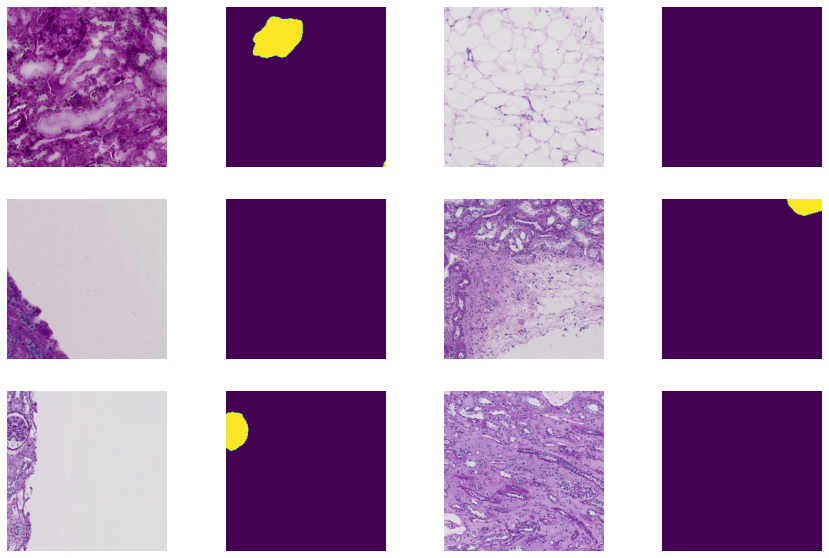

In [ ]:
# base augmentation
train_dataset = HuBMAPDataset(main_dir, train_df, train=True, transform=get_transform('base'))

vis_aug_data(train_dataset, 6)

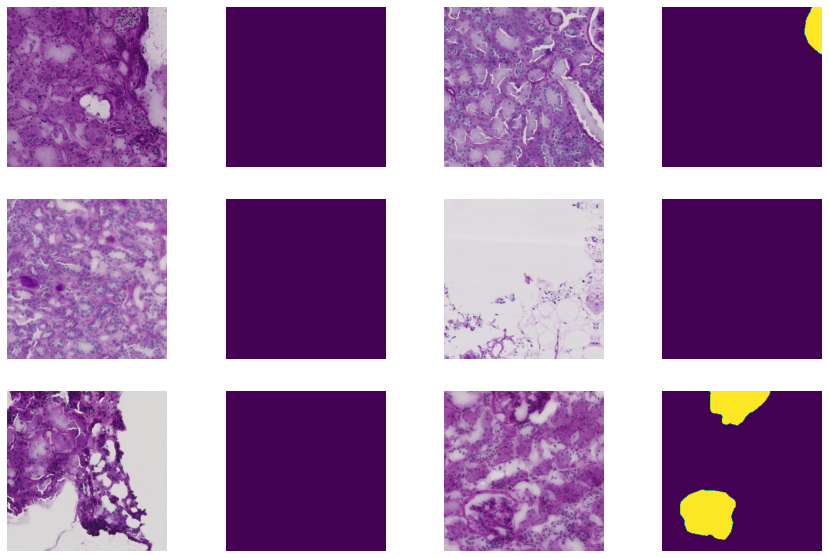

In [ ]:
# weak augmentation
train_dataset = HuBMAPDataset(main_dir, train_df, train=True, transform=get_transform('weak'))

vis_aug_data(train_dataset, 6)

In [ ]:
# strong augmentation
train_dataset = HuBMAPDataset(main_dir, train_df, train=True, transform=get_transform('strong'))

vis_aug_data(train_dataset, 6)

In [ ]:
# valid augmentation
train_dataset = HuBMAPDataset(main_dir, train_df, train=True, transform=get_transform('valid'))

vis_aug_data(train_dataset, 6)

## DataLoader

In [ ]:
if CFG.data==256:
    directory_list = os.listdir(train_dir)
directory_list = [fnames.split('_')[0] for fnames in directory_list]
dir_df = pd.DataFrame(directory_list, columns=['id'])
dir_df

,id
0,4ef6695ce
1,cb2d976f4
2,54f2eec69
3,b2dc8411c
4,8242609fa
...,...
9575,095bf7a1f
9576,cb2d976f4
9577,095bf7a1f
9578,afa5e8098


## Model

In [ ]:
!wget https://storage.googleapis.com/vit_models/imagenet21k/R50%2BViT-B_16.npz
#! pip install self-attention-cv
!pip install einops
!pip install ml_collections

--2021-05-21 17:31:55--  https://storage.googleapis.com/vit_models/imagenet21k/R50%2BViT-B_16.npz
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.126.128, 108.177.127.128, 142.250.153.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.126.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 461217452 (440M) [application/octet-stream]
Saving to: ‘R50+ViT-B_16.npz’

R50+ViT-B_16.npz    100%[===================>] 439.85M   125MB/s    in 3.5s    

2021-05-21 17:31:59 (125 MB/s) - ‘R50+ViT-B_16.npz’ saved [461217452/461217452]

     |████████████████████████████████| 92kB 7.1MB/s 


In [ ]:
!git clone https://github.com/Beckschen/TransUNet.git
import sys
sys.path.append('/content/TransUNet/')
!pip install ml-collections
from TransUNet.networks.vit_seg_modeling import VisionTransformer as ViT_seg

Cloning into 'TransUNet'...
remote: Enumerating objects: 92, done.
remote: Counting objects: 100% (92/92), done.
remote: Compressing objects: 100% (77/77), done.
remote: Total 92 (delta 47), reused 38 (delta 14), pack-reused 0
Unpacking objects: 100% (92/92), done.


In [ ]:
from networks.vit_seg_modeling import VisionTransformer as ViT_seg
from networks.vit_seg_modeling import CONFIGS as CONFIGS_ViT_seg

config_vit = CONFIGS_ViT_seg[CFG.MODEL_NAME]
config_vit.n_classes = 1
config_vit.n_skip = 3
config_vit.pretrained_path = './R50+ViT-B_16.npz'
config_vit.transformer.dropout_rate = 0.2
config_vit.transformer.mlp_dim = 3072
config_vit.transformer.num_heads = 4
config_vit.transformer.num_layers = 8
config_vit.hybrid=False

config_vit

activation: softmax
classifier: seg
decoder_channels: !!python/tuple
- 256
- 128
- 64
- 16
hidden_size: 768
hybrid: false
n_classes: 1
n_skip: 3
patch_size: 16
patches:
  grid: !!python/tuple
  - 16
  - 16
  size: !!python/tuple
  - 16
  - 16
pretrained_path: ./R50+ViT-B_16.npz
representation_size: null
resnet:
  num_layers: !!python/tuple
  - 3
  - 4
  - 9
  width_factor: 1
resnet_pretrained_path: null
skip_channels:
- 512
- 256
- 64
- 16
transformer:
  attention_dropout_rate: 0.0
  dropout_rate: 0.2
  mlp_dim: 3072
  num_heads: 4
  num_layers: 8

In [ ]:
class ViTHuBMAP(nn.Module):
    def __init__(self, configs=config_vit):
        super(ViTHuBMAP, self).__init__()
        
        self.model = ViT_seg(configs, img_size=CFG.img_size, num_classes=CFG.classes)
        #self.model.load_from(weights=np.load(configs.pretrained_path))

    
    def forward(self, x):
        img_segs = self.model(x)
        
        return img_segs

In [ ]:
config_vit.hybrid

False

## Loss Function

In [ ]:
!git clone https://github.com/JunMa11/SegLoss.git
sys.path.append('/content/SegLoss/')
from losses_pytorch.hausdorff import HausdorffDTLoss
from losses_pytorch.lovasz_loss import LovaszSoftmax
from losses_pytorch.focal_loss import FocalLoss

fatal: destination path 'SegLoss' already exists and is not an empty directory.


In [ ]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=CFG.smoothing):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return dice
    
class DiceScore(nn.Module):
    # Formula Given above.
    def __init__(self, weight=None, size_average=True):
        super(DiceScore, self).__init__()

    def forward(self, inputs, targets, smooth=CFG.smoothing):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        inputs = (inputs >= 0.5).float()
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_score = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth) 
        return dice_score
    
class DiceBCELoss(nn.Module):
    # Formula Given above.
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=CFG.smoothing):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).mean()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.mean() + targets.mean() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss
        
        return Dice_BCE.mean()
    
    
class Hausdorff_loss(nn.Module):
    def __init__(self):
        super(Hausdorff_loss, self).__init__()
        
    def forward(self, inputs, targets):
        return HausdorffDTLoss()(inputs, targets)
    
class FocalDLoss(nn.Module):
    def __init__(self):
        super(FocalDLoss, self).__init__()
        
    def forward(self, inputs, targets):
        return FocalLoss()(inputs, targets)
    
    
class Lovasz_loss(nn.Module):
    def __init__(self):
        super(Lovasz_loss, self).__init__()
        
    def forward(self, inputs, targets):
        return LovaszSoftmax()(inputs, targets)

In [ ]:
if CFG.criterion == 'DiceBCELoss':
    criterion = DiceBCELoss()
elif CFG.criterion == 'DiceLoss':
    criterion = DiceLoss()
elif CFG.criterion == 'FocalLoss':
    criterion = FocalDLoss()
elif CFG.criterion == 'Hausdorff':
    criterion = Hausdorff_loss()
elif CFG.criterion == 'Lovasz':
    criterion = Lovasz_loss()

## Train Function

In [ ]:
def HuBMAPLoss(images, targets, model, device, loss_func=criterion):
    model.to(device)
    images = images.to(device)
    targets = targets.to(device)
    outputs = model(images)
    loss_func = loss_func
    loss = loss_func(outputs, targets)
    return loss, outputs

def HuBMAPScore(images, targets, model, device, loss_func=criterion):
    model.to(device)
    images = images.to(device)
    targets = targets.to(device)
    outputs = model(images)
    scoreM = DiceScore()
    score = scoreM(outputs, targets)
    return score

In [ ]:
def train_one_epoch(epoch, model, device, optimizer, scheduler, trainloader):
    model.train()
    t = time.time()
    total_loss = 0
    total_score = 0
    for step, (images, targets) in enumerate(trainloader):
        loss, outputs = HuBMAPLoss(images, targets, model, device)
        loss.backward()
        if ((step+1)%4==0 or (step+1)==len(trainloader)):
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
        loss = loss.detach().item()
        total_loss += loss

        model.eval()
        score = HuBMAPScore(images, targets, model, device).detach().item()
        total_score += score
        model.train()
        
        if ((step+1)%10==0 or (step+1)==len(trainloader)):
            print(
                    f'epoch {epoch} train step {step+1}/{len(trainloader)}, ' + \
                    f'loss: {total_loss/len(trainloader):.4f}, ' + \
                    f'time: {(time.time() - t):.4f}', end= '\r' if (step + 1) != len(trainloader) else '\n'
                )
    return total_score / len(trainloader)

def valid_one_epoch(epoch, model, device, optimizer, scheduler, validloader):
    model.eval()
    t = time.time()
    total_loss = 0
    total_score = 0
    for step, (images, targets) in enumerate(validloader):
        loss, outputs = HuBMAPLoss(images, targets, model, device)
        
        loss = loss.detach().item()
        total_loss += loss
        
        score = HuBMAPScore(images, targets, model, device).detach().item()
        total_score += score
        
        if ((step+1)%4==0 or (step+1)==len(validloader)):
            scheduler.step(total_loss/len(validloader))
        
        if ((step+1)%10==0 or (step+1)==len(validloader)):
            print(
                    f'**epoch {epoch} trainz step {step+1}/{len(validloader)}, ' + \
                    f'loss: {total_loss/len(validloader):.4f}, ' + \
                    f'time: {(time.time() - t):.4f}', end= '\r' if (step + 1) != len(validloader) else '\n'
                )
    return total_score / len(validloader)

def get_score(model, device, optimizer, scheduler, validloader):
    model.eval()
    t = time.time()
    total_score = 0
    for step, (images, targets) in enumerate(validloader):
        score = HuBMAPScore(images, targets, model, device).detach().item()
        total_score += score
    return total_score

In [ ]:
CFG.criterion

'DiceBCELoss'

## Creating Folds Column

In [ ]:
FOLDS = CFG.n_fold
gkf = GroupKFold(FOLDS)
dir_df['Folds'] = 0
for fold, (tr_idx, val_idx) in enumerate(gkf.split(dir_df[:5000], groups=dir_df[dir_df.columns[0]][:5000].values)):
    dir_df.loc[val_idx, 'Folds'] = fold
    
dir_df = dir_df[:5000]

## The Real Training

In [ ]:
def prepare_train_valid_dataloader(df, fold):
    train_ids = df[~df.Folds.isin(fold)]
    val_ids = df[df.Folds.isin(fold)]
    
    train_ds = HuBMAPDataset(main_dir, train_ids, train=True, transform=get_transform('base'))
    val_ds = HuBMAPDataset(main_dir, val_ids, train=True, transform=get_transform('valid'))
    
    train_loader = DataLoader(train_ds, batch_size=CFG.batch_size, pin_memory=True, shuffle=True, num_workers=CFG.num_workers)
    val_loader = DataLoader(val_ds, batch_size=CFG.batch_size, pin_memory=True, shuffle=False, num_workers=CFG.num_workers)
    
    return train_loader, val_loader

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = ViTHuBMAP().to(device)
optimizer = Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay, amsgrad=False)

# scheduler setting
if CFG.scheduler == 'CosineAnnealingWarmRestarts':
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
elif CFG.scheduler == 'ReduceLROnPlateau':
    scheduler = ReduceLROnPlateauReduceLROnPlateau(optimizer, mode='min', factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps)
elif CFG.scheduler == 'CosineAnnealingLR':
    scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)

In [ ]:
dir_df

In [ ]:
print(f'Training Loop [{CFG.trn_fold}]...')
for fold, (tr_idx, val_idx) ind enumerate(gkf.split(dir_df, groups=dir_df[dir_df.columns[0]].values)):
    if fold != CFG.trn_fold: # Train only one fold
        continue 

    trainloader, validloader = prepare_train_valid_dataloader(dir_df, [fold])

    for epoch in range(CFG.epoch):
        avg_dice_train += train_one_epoch(epoch, model, device, optimizer, scheduler, trainloader)
        with torch.no_grad():
            avg_dice_valid += valid_one_epoch(epoch, model, device, optimizer, scheduler, validloader)
        
        #torch.save(model.state_dict(),f'FOLD-{fold}-EPOCH-{epoch}-model.pth')
        
    torch.save(model.state_dict(),f'FOLD-{fold}-model.pth')
    
    #del model, optimizer, scheduler, trainloader, validloader

Training Loop [0]...
epoch 0 train step 1921/1921, loss: 0.1039, time: 486.4288
**epoch 0 trainz step 475/475, loss: 0.0178, time: 30.5330
epoch 1 train step 1921/1921, loss: 0.0205, time: 484.8455
**epoch 1 trainz step 475/475, loss: 0.0110, time: 29.7477
epoch 2 train step 1921/1921, loss: 0.0190, time: 482.0886
**epoch 2 trainz step 475/475, loss: 0.0189, time: 29.8056
epoch 3 train step 1921/1921, loss: 0.0181, time: 484.4508
**epoch 3 trainz step 475/475, loss: 0.0128, time: 29.8187
epoch 4 train step 1921/1921, loss: 0.0166, time: 486.0959
**epoch 4 trainz step 475/475, loss: 0.0157, time: 29.9840


In [ ]:
torch.save(model.state_dict(),'/content/ResNetTransUNet-model.pt')
files.download('/content/ResNetTransUNet-model.pt') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
torch.save(model.state_dict(),'/content/drive/MyDrive/DLProjectData/TransUNetNoHybrid-model.pth')

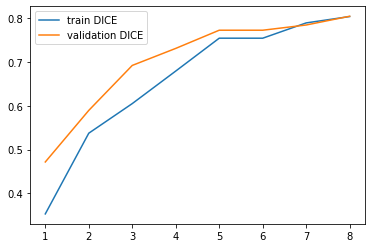

0.7948541193482995
0.8045818715850136


In [ ]:
epochs = 8
plt.plot(np.linspace(1, epochs, epochs), avg_dice_train, label="train DICE")
plt.plot(np.linspace(1, epochs, epochs), avg_dice_valid, label="validation DICE")
plt.legend()
plt.show()

print(get_score(model, device, optimizer, scheduler, trainloader) / len(trainloader))
print(get_score(model, device, optimizer, scheduler, validloader) / len(validloader))

from google.colab import files

In [ ]:
trainloader, validloader = prepare_train_valid_dataloader(dir_df, [0])
avg_dice_train, avg_dice_valid = [], []
for epoch in range(8):
    avg_dice_train.append(train_one_epoch(epoch, model, device, optimizer, scheduler, trainloader))
    with torch.no_grad():
        avg_dice_valid.append(valid_one_epoch(epoch, model, device, optimizer, scheduler, validloader))
    
    #torch.save(model.state_dict(),f'FOLD-{fold}-EPOCH-{epoch}-model.pth')
    
torch.save(model.state_dict(),'/content/drive/MyDrive/DLProjectData/TransUNet-model.pth')

#del model,

epoch 0 train step 1921/1921, loss: 0.5670, time: 458.5024
**epoch 0 trainz step 475/475, loss: 0.3278, time: 38.9944
epoch 1 train step 1921/1921, loss: 0.2615, time: 447.3438
**epoch 1 trainz step 475/475, loss: 0.1843, time: 38.5904
epoch 2 train step 1921/1921, loss: 0.1567, time: 445.0390
**epoch 2 trainz step 475/475, loss: 0.1149, time: 38.7095
epoch 3 train step 1921/1921, loss: 0.1017, time: 453.0296
**epoch 3 trainz step 475/475, loss: 0.0777, time: 38.6714
epoch 4 train step 1921/1921, loss: 0.0697, time: 451.4395
**epoch 4 trainz step 475/475, loss: 0.0580, time: 38.7212
epoch 5 train step 1921/1921, loss: 0.0600, time: 457.9898
**epoch 5 trainz step 475/475, loss: 0.0484, time: 38.8074
epoch 6 train step 1921/1921, loss: 0.0456, time: 456.1084
**epoch 6 trainz step 475/475, loss: 0.0413, time: 38.6730
epoch 7 train step 1921/1921, loss: 0.0399, time: 450.7803
**epoch 7 trainz step 475/475, loss: 0.0351, time: 38.5961


In [ ]:
#Get DICESCORE
totalDICE = get_score(model, device, optimizer, scheduler, trainloader)

In [ ]:
valid_one_epoch(epoch, model, device, optimizer, scheduler, validloader)

**epoch 4 trainz step 471/471, loss: 0.0594, time: 55.8813


0.8688274212031105

## Plot the results 

In [ ]:
trainloader, validloader = prepare_train_valid_dataloader(dir_df, [4])

In [ ]:
def plot_result(validloader, n_sample=4):
    img, mask = next(iter(validloader))
    model.load_state_dict(torch.load(f'./FOLD-{CFG.trn_fold}-model.pth'))
    pred_mask = model(img.to(device)).squeeze(1).cpu().detach()
    
    N = n_sample // 2
    assert (N < CFG.batch_size)
    plt.figure(figsize=(15, 20))
    for i in range(n_sample):
        plt.subplot(N, 4, 2*i+1)
        plt.imshow(np.transpose(img[i], (1,2,0)))
        plt.axis('off')
        
        plt.subplot(N, 4, 2*i+2)
        plt.imshow(pred_mask[i])
        plt.axis('off')

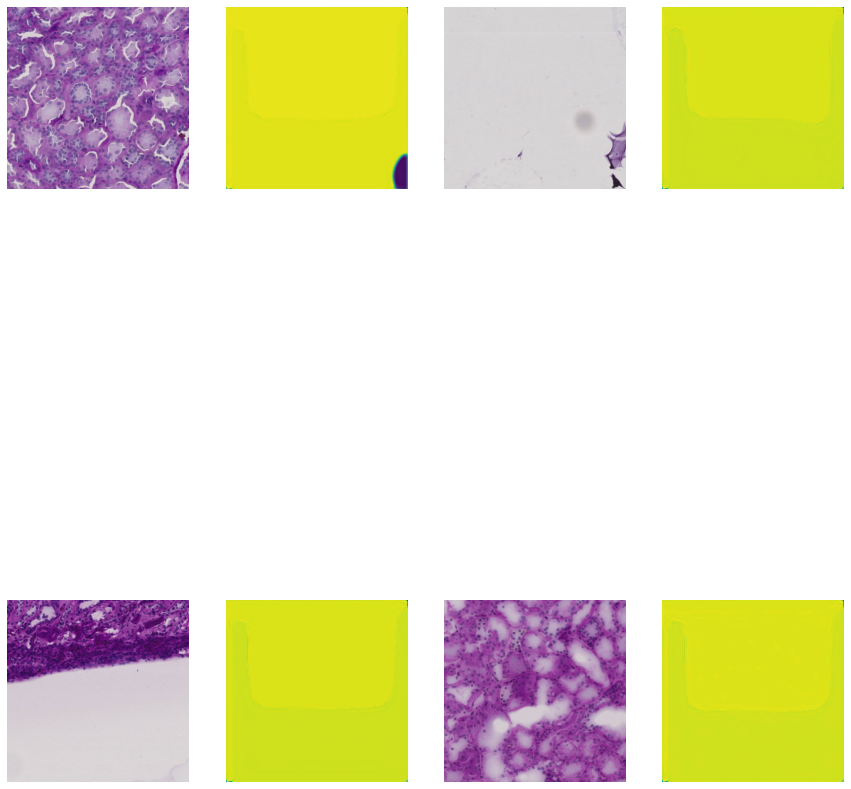

In [ ]:
with torch.no_grad():
    plot_result(validloader)

## What you should do to improve the results:
- Use data normalization
- Use anthor implementation for TransUnet (Applied in V16)
- Reduce the probability of the augmentations
- Play with visionTrans hyperparameters

<CENTER><h3><span style='color:red'> UPVOTE </span> If you liked</h3>
<h4>Code still under modifications, Stay tuned</h4></CENTER>